In [1]:
import pymc3 as pm
import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Simple Linear regression
## The core of the linear regression models

By using a fully probabilistic model instead of a a model based on least squares optimisation we also get estimation of the uncertainty of our parameters.  

It is reasnoably to assume:
* $\alpha \sim Gaussian$
* $\beta \sim Gaussian$
* $\epsilon \sim HalfNormal$ with 0 as mean. HalfCauchy can be used for regularization


In [2]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)
x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x

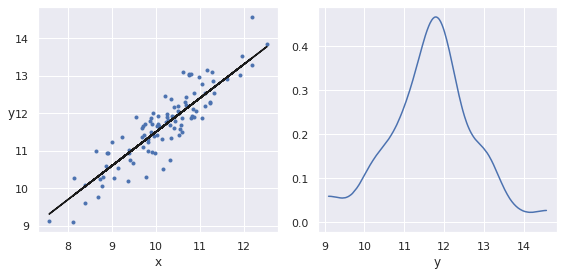

In [3]:
y = y_real + eps_real
_, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()

In [8]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ε = pm.HalfCauchy('ε', 5)
    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=y)
    trace_g = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β, α]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:15<00:00, 390.47draws/s]
The acceptance probability does not match the target. It is 0.8851913476777811, but should be close to 0.8. Try to increase the number of tuning steps.


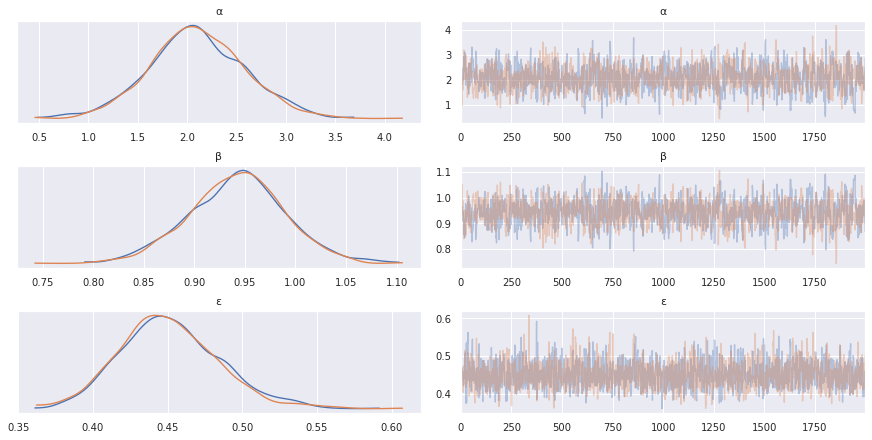

In [9]:
with model_g:
    az.plot_trace(trace_g, var_names=['α', 'β', 'ε'])

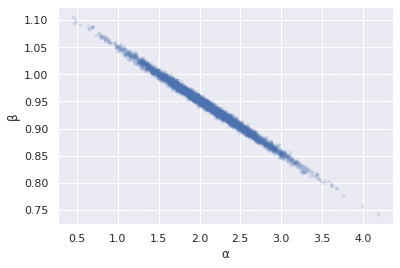

In [11]:
with model_g:
    az.plot_pair(trace_g, var_names=['α', 'β'], scatter_kwargs={'alpha': 0.1})

The plot shows the strong correlation between alpha and beta parameters.
By centering X we the correlation is removed.  

More, if you standardize the data ( both x and y ) you can always use the same weakly informative priors.
Can also help interpretability.If you have -1.3 in Z-score for a parameter we know that it is 1.3 standard deviations below the mean.

Everything on the same scale helps interpretability.

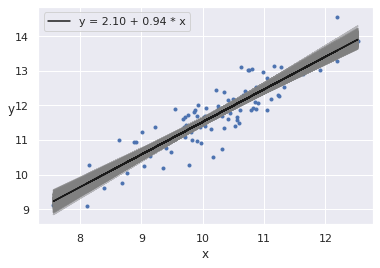

In [16]:
plt.plot(x, y, 'C0.')
alpha_m = trace_g['α'].mean()
beta_m = trace_g['β'].mean()
draws = range(0, len(trace_g['α']), 10)
plt.plot(x, trace_g['α'][draws] + trace_g['β'][draws]
* x[:, np.newaxis], c='gray', alpha=0.5) ## Represent uncertainty
plt.plot(x, alpha_m + beta_m * x, c='k',
label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

/home/carl/miniconda3/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
No handles with labels found to put in legend.


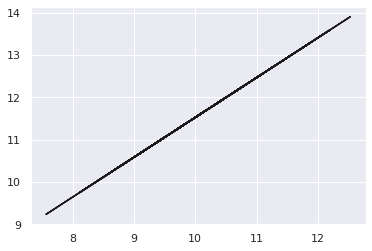

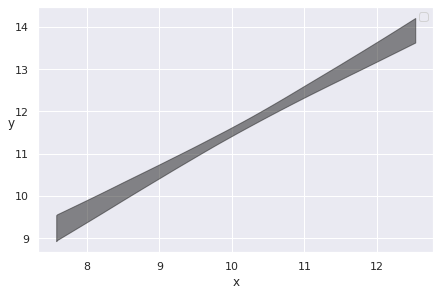

In [27]:
# Instead of sampling for alphas and betas we can plot the hpd directly
with model_g:
    plt.plot(x, alpha_m + beta_m * x, c='k',
    label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    sig = az.plot_hdi(x, trace_g['μ'], hdi_prob=0.98, color='k')
    plt.xlabel('x')
    plt.ylabel('y', rotation=0)
    plt.legend()
    plt.show()

In [28]:
ppc = pm.sample_posterior_predictive(trace_g,
samples=2000,
model=model_g)

/home/carl/miniconda3/lib/python3.8/site-packages/pymc3/sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████| 2000/2000 [00:02<00:00, 774.28it/s]


/home/carl/miniconda3/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/carl/miniconda3/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0, 0.5, 'y')

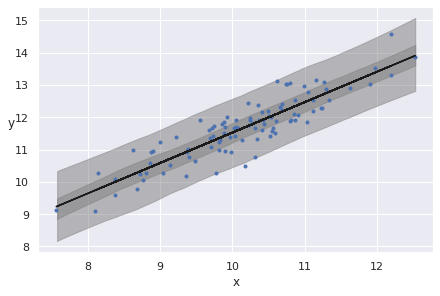

In [56]:
# fig1, ax = plt.subplots()
a1 = az.plot_hpd(x, ppc['y_pred'], hdi_prob=0.98, color='gray')
a2 = az.plot_hpd(x, ppc['y_pred'], hdi_prob=0.5,color='gray', ax=a1)
a1.plot(x, y, 'b.')
a1.plot(x, alpha_m + beta_m * x, c='k',
    label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
plt.xlabel('x')
plt.ylabel('y', rotation=0)


### Robust linear regression

In [60]:
from scipy import stats

In [58]:
ans = pd.read_csv('data/anscombe.csv')
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()

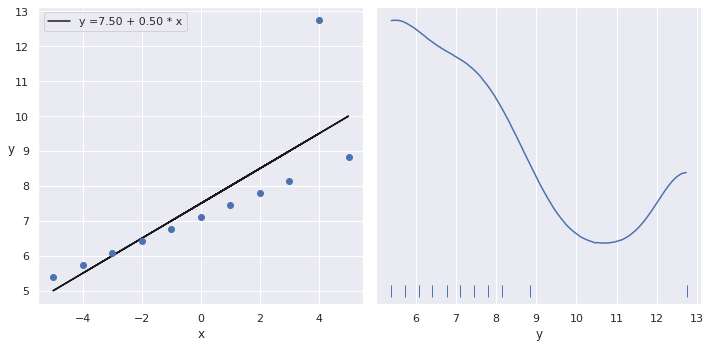

In [61]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
ax[0].plot(x_3, (alpha_c + beta_c * x_3), 'k',
label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_3, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()

In [78]:
with pm.Model() as model_t:
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ε = pm.HalfNormal('ε', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)
    y_pred = pm.StudentT('y_pred', mu=α + β * x_3,
    sd=ε, nu=ν, observed=y_3)
    trace_t = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_, ε, β, α]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:07<00:00, 643.42draws/s] 
The number of effective samples is smaller than 25% for some parameters.


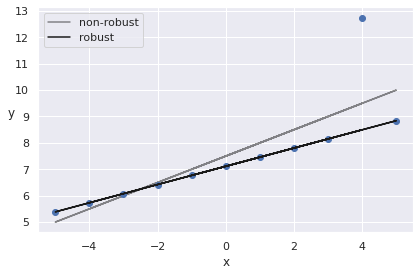

In [79]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')
alpha_m = trace_t['α'].mean()
beta_m = trace_t['β'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)
plt.tight_layout()

In [80]:
## Using a student t distribution gives a more robust prediction

In [81]:
az.summary(trace_t)

/home/carl/miniconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,7.114,0.001,7.112,7.117,0.000,0.000,2468.0,2468.0,2534.0,2142.0,1.0
β,0.345,0.000,0.345,0.346,0.000,0.000,1937.0,1933.0,2492.0,2052.0,1.0
ε,0.003,0.002,0.001,0.006,0.000,0.000,1185.0,1185.0,753.0,320.0,1.0
ν_,0.206,0.199,0.000,0.568,0.004,0.003,2618.0,2618.0,1172.0,414.0,1.0
ν,1.206,0.199,1.000,1.568,0.004,0.003,2618.0,2618.0,1172.0,414.0,1.0


/home/carl/miniconda3/lib/python3.8/site-packages/pymc3/sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████| 200/200 [00:00<00:00, 675.38it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive variable y_pred's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


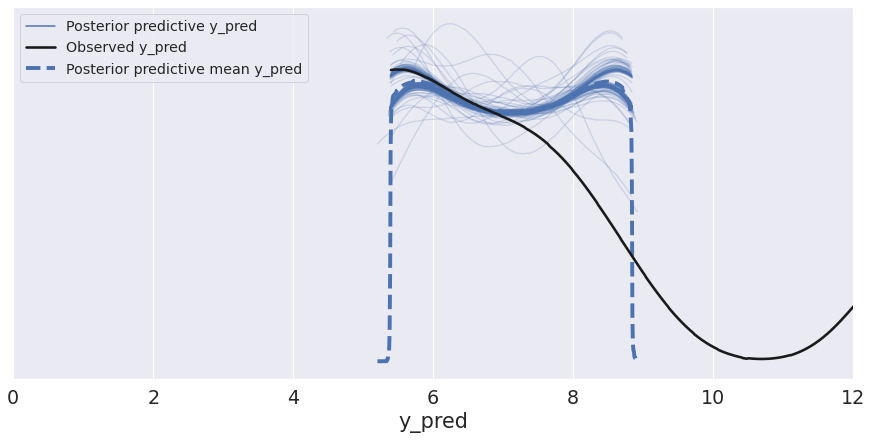

In [82]:
with model_t:
    ppc = pm.sample_posterior_predictive(trace_t, samples=200, model=model_t,
        random_seed=2)
    data_ppc = az.from_pymc3(trace=trace_t, posterior_predictive=ppc)
    ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
    plt.xlim(0, 12)

## Hierarchhical linear regression

In [95]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

In [91]:
alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

In [92]:
y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

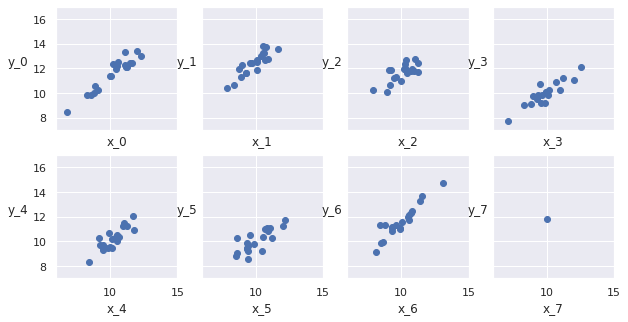

In [99]:
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N

In [100]:
x_centered = x_m - x_m.mean()

In [101]:
# Unpooled model
with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10, shape=M)
    β = pm.Normal('β', mu=0, sd=10, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    υ = pm.Exponential('υ', 1/30)
    
    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered, sd=ϵ, nu=υ, observed=y_m)
    α = pm.Deterministic('α', α_tmp - β *x_m.mean())
    
    trace_up = pm.sample(2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [υ, ϵ, β, α_tmp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:07<00:00, 666.58draws/s] 


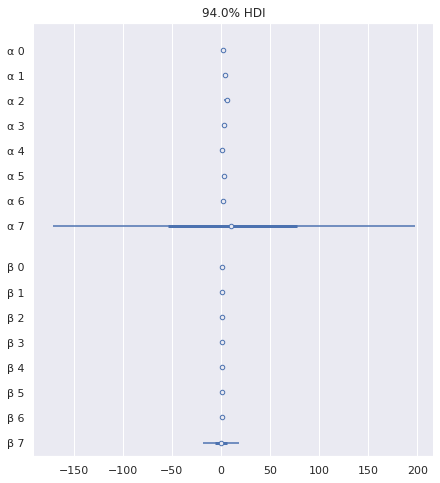

In [103]:
with unpooled_model:
    az.plot_forest(trace_up, var_names=['α', 'β'], combined=True)

In [104]:
## Hierarchical model
with pm.Model() as model_h:
    # hyper_priors
    alpha_mu_hp = pm.Normal("alpha_mu_hp", mu=0, sd=10)
    alpha_sigma_hp = pm.HalfNormal("alpha_sigma_hp", 10)
    beta_mu_hp = pm.Normal("beta_mu_hp", mu=0, sd=10)
    beta_sigma_hp = pm.HalfNormal("beta_sigma_hp", 10)
    
    # priors
    alpha = pm.Normal("alpha", mu=alpha_mu_hp, sd=alpha_sigma_hp, shape=M)
    beta = pm.Normal("beta", mu=beta_mu_hp, sd=beta_sigma_hp, shape=M)
    epsilon = pm.HalfCauchy("epsilon", 5)
    nu = pm.Exponential('nu', 1/30)
    
    y_pred = pm.StudentT('y_pred', mu=alpha[idx] + beta[idx]*x_centered,
                         sd=epsilon, nu=nu, observed=y_m)
    
    # Transform back for interpretability
    alpha_back = pm.Deterministic("alpha_back", alpha - beta*x_m.mean())
    alpha_back_mu = pm.Deterministic("alpha_mu_back",
                                     alpha_mu_hp - beta_mu_hp*x_m.mean())
    alpha_back_sigma = pm.Deterministic("alpha_back_sigma", alpha_sigma_hp - beta_mu_hp*x_m.mean())
    
    trace_mh = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, epsilon, beta, alpha, beta_sigma_hp, beta_mu_hp, alpha_sigma_hp, alpha_mu_hp]
Sampling 2 chains, 61 divergences: 100%|██████████| 3000/3000 [00:08<00:00, 352.56draws/s]
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


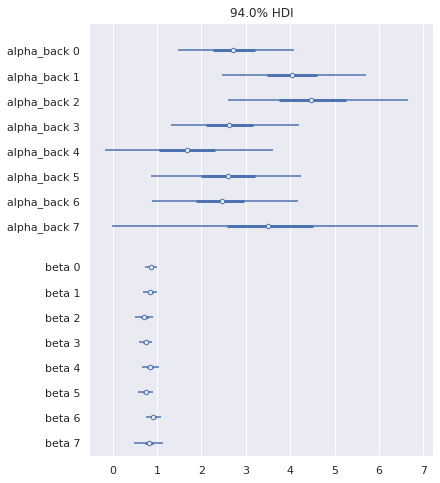

In [109]:
with model_h:
    az.plot_forest(trace_mh, var_names=['alpha_back', 'beta'], combined=True)

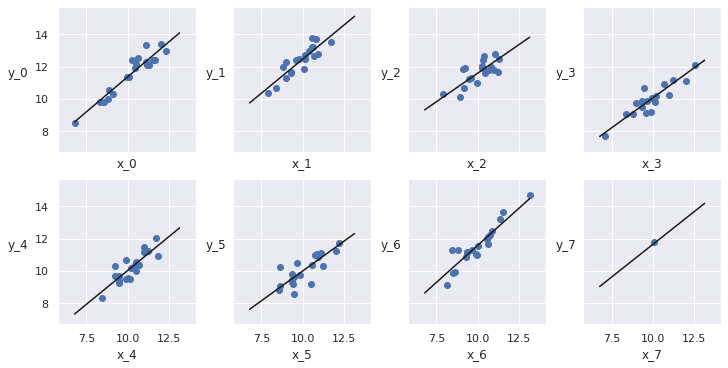

In [112]:
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True,
constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_mh['alpha_back'][:, i].mean()
    beta_m = trace_mh['beta'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
    label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N

# Polynomial regression - speed through 

Text(0, 0.5, 'y')

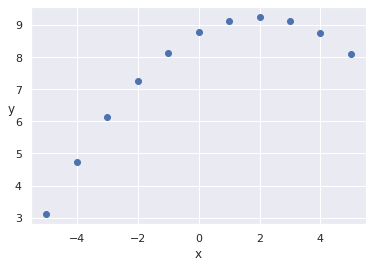

In [113]:
x_2 = ans[ans.group == 'II']['x'].values
y_2 = ans[ans.group == 'II']['y'].values
x_2 = x_2 - x_2.mean()
plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)

In [114]:
with pm.Model() as model_poly:
    α = pm.Normal('α', mu=y_2.mean(), sd=1)
    β1 = pm.Normal('β1', mu=0, sd=1)
    β2 = pm.Normal('β2', mu=0, sd=1)
    ε = pm.HalfCauchy('ε', 5)
    mu = α + β1 * x_2 + β2 * x_2**2
    y_pred = pm.Normal('y_pred', mu=mu, sd=ε, observed=y_2)
    trace_poly = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β2, β1, α]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:07<00:00, 700.04draws/s] 
The acceptance probability does not match the target. It is 0.9265321165190988, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9191891457654572, but should be close to 0.8. Try to increase the number of tuning steps.


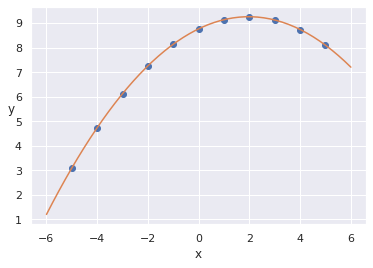

In [115]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['α'].mean() + trace_poly['β1'].mean() * \
x_p + trace_poly['β2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1')

# Multiple linear regression - speed through

In [116]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)
X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1,
1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

In [126]:
beta_real

[0.9, 1.5]

In [120]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)
    plt.subplot(2, 2, idx+2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)

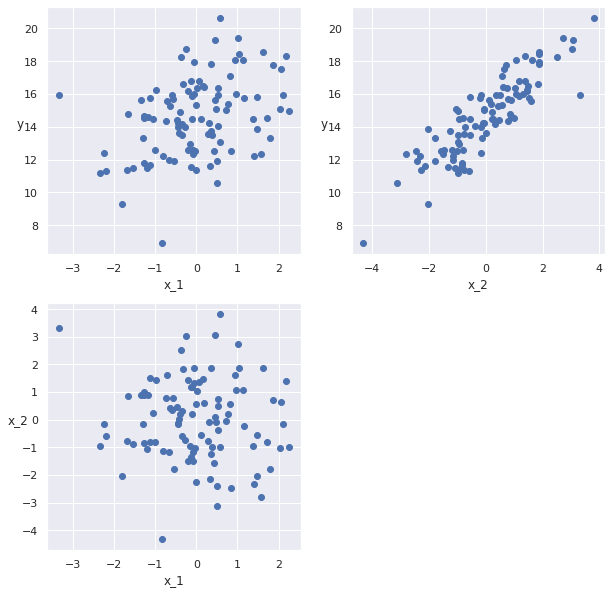

In [121]:
scatter_plot(X_centered, y)

In [122]:
with pm.Model() as model_mlr:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    ε = pm.HalfCauchy('ε', 5)
    μ = α_tmp + pm.math.dot(X_centered, β)
    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=y)
    trace_mlr = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β, α_tmp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:04<00:00, 1124.34draws/s]


In [124]:
# varnames = ['α', 'β', 'ε']
az.summary(trace_mlr, var_names=varnames)

/home/carl/miniconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α[0],1.855,0.450,0.991,2.647,0.007,0.005,4453.0,4366.0,4475.0,3221.0,1.0
β[0],0.968,0.043,0.889,1.049,0.001,0.000,4545.0,4531.0,4567.0,3389.0,1.0
β[1],1.470,0.033,1.410,1.533,0.000,0.000,4670.0,4643.0,4658.0,2880.0,1.0
ε,0.474,0.035,0.408,0.538,0.001,0.000,3775.0,3708.0,3852.0,3004.0,1.0


## Confounding variables and redundant variables
Confounding variable example: Z is responsible for causing x and y. We could see a correlation between x and y, but it is in reality z that is the cause.


In [127]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

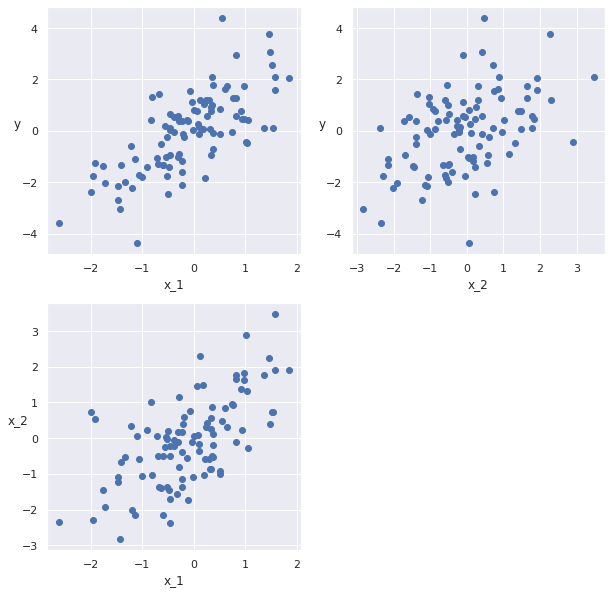

In [128]:
scatter_plot(X, y)

In [129]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ε = pm.HalfCauchy('ε', 5)
    μ = α + β1 * X[:, 0] + β2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=y)
    trace_x1x2 = pm.sample(2000)
with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ε = pm.HalfCauchy('ε', 5)
    μ = α + β1 * X[:, 0]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=y)
    trace_x1 = pm.sample(2000)
with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ε = pm.HalfCauchy('ε', 5)
    μ = α + β2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=y)
    trace_x2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β2, β1, α]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:03<00:00, 1462.45draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β1, α]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:02<00:00, 1923.01draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β2, α]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:03<00:00, 1377.79draws/s]


/home/carl/miniconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe850ef7e50>],
      dtype=object)

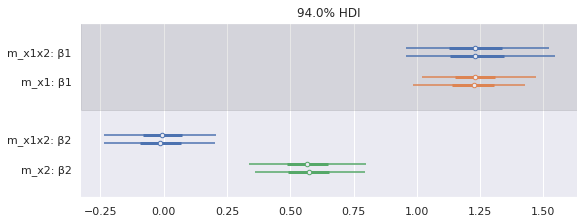

In [130]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
model_names=['m_x1x2', 'm_x1', 'm_x2'],
var_names=['β1', 'β2'],
combined=False, colors='cycle', figsize=(8, 3))

In [131]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

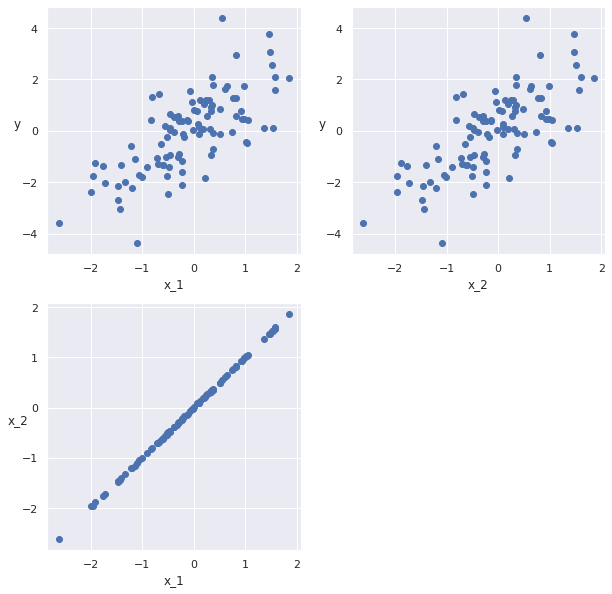

In [132]:
scatter_plot(X, y)